## 1. Setup and Imports 🚀

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
import random
from torch.optim import Adam
from sklearn.metrics import roc_curve, precision_recall_curve
from torch_geometric.nn import VGAE

# Import custom modules
from src.utils import device, set_seed, get_loss, aggregate_stats, reconstruct_graph
from src.model import Encoder
from src.training import train_and_evaluate
from src.preprocessing import load_and_prepare_data
from src.visualization import plot_training_curves, plot_reconstruction_analysis, plot_geographical_comparison # NEW IMPORT

# Set device and global seed
GLOBAL_SEED = 8
set_seed(GLOBAL_SEED)
print(f"Using device: {device}")

Using device: cuda


## 1 - Graph Loading and Preprocessing ⚙️

In [11]:
FILEPATH = "data/airportsAndCoordAndPop.graphml"
DEGREE_THRESHOLD = 5

data, G, X_ohe_tensor = load_and_prepare_data(
    filepath=FILEPATH, 
    degree_threshold=DEGREE_THRESHOLD, 
    device=device
)

print(f"\n--- Prepared Data Summary ---")
print(f"Number of nodes: {data.num_nodes}")
in_channels = data.num_node_features
print(f"in_channels: {in_channels}")

--- 1. Graph Loading and Cleaning ---
Remaining nodes after filtering (D<=5): 660
Remaining edges: 8142
Removed nodes: 2703
Min degree: 6
Avg degree: 24.67
Density: 0.0374

--- 2. Edge Splitting and Finalization ---
Training edges: 11400
Validation edges: 814
Test edges: 1628

--- Prepared Data Summary ---
Number of nodes: 660
in_channels: 173


## 2 - Model Definition and Setup 🏗️

In [12]:
# Model parameters
hidden_channels = 128
out_channels = 16

encoder = Encoder(in_channels, hidden_channels, out_channels, dropout=0.3).to(device)
model = VGAE(encoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"\n2-layer VGAE model created with out_channels={out_channels}")


2-layer VGAE model created with out_channels=16


## 3 - TRAINING & EVALUATION (Multi-Run) 🏋️

In [13]:
n_runs = 5
test_aucs, test_aps = [], []
all_histories = []

for run in range(n_runs):
    print(f"\n{'='*50}")
    print(f"Run {run+1}/{n_runs}")
    print('='*50)
    
    # Re-initialize model and optimizer for a fresh start in each run
    encoder = Encoder(in_channels, hidden_channels, out_channels, dropout=0.3).to(device)
    model = VGAE(encoder).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    auc, ap, train_losses, val_losses, val_aucs, val_aps = train_and_evaluate(
        run_seed=GLOBAL_SEED + run,
        data=data, 
        device=device,
        model=model,
        optimizer=optimizer
    )
    
    test_aucs.append(auc)
    test_aps.append(ap)
    all_histories.append({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_aucs': val_aucs,
        'val_aps': val_aps
    })
    
    print(f"\nRun {run+1} Final Results: AUC = {auc:.4f}, AP = {ap:.4f}")

# Compute and print statistics
stats = aggregate_stats(test_aucs, test_aps, n_runs)
mean_auc, ci_auc, mean_ap, ci_ap = stats['mean_auc'], stats['ci_auc'], stats['mean_ap'], stats['ci_ap']
std_auc, std_ap = stats['std_auc'], stats['std_ap']

print("\n" + "="*50)
print("FINAL LINK PREDICTION RESULTS (mean ± 95% CI)")
print("="*50)
print(f"AUC: {mean_auc:.4f} ± {ci_auc:.4f} [{mean_auc-ci_auc:.4f}, {mean_auc+ci_auc:.4f}]")
print(f"AP:  {mean_ap:.4f} ± {ci_ap:.4f} [{mean_ap-ci_ap:.4f}, {mean_ap+ci_ap:.4f}]")


Run 1/5
Epoch 050 | Train: 1.6013 | Val Loss: 1.3347 | AUC: 0.8258 | AP: 0.8400 | Patience: 0/50
Epoch 100 | Train: 1.1031 | Val Loss: 1.0989 | AUC: 0.8846 | AP: 0.8804 | Patience: 0/50
Epoch 150 | Train: 0.9621 | Val Loss: 0.9664 | AUC: 0.9158 | AP: 0.9067 | Patience: 0/50
Epoch 200 | Train: 0.8877 | Val Loss: 0.8950 | AUC: 0.9293 | AP: 0.9205 | Patience: 0/50
Epoch 250 | Train: 0.8201 | Val Loss: 0.9243 | AUC: 0.9420 | AP: 0.9336 | Patience: 0/50
Epoch 300 | Train: 0.7914 | Val Loss: 0.9181 | AUC: 0.9436 | AP: 0.9350 | Patience: 36/50
Epoch 350 | Train: 0.7723 | Val Loss: 0.8251 | AUC: 0.9467 | AP: 0.9382 | Patience: 36/50
Epoch 400 | Train: 0.7590 | Val Loss: 0.8278 | AUC: 0.9459 | AP: 0.9383 | Patience: 13/50
Epoch 450 | Train: 0.7406 | Val Loss: 0.8453 | AUC: 0.9478 | AP: 0.9397 | Patience: 24/50
Early stopping at epoch 476

Run 1 Final Results: AUC = 0.9530, AP = 0.9494

Run 2/5
Epoch 050 | Train: 1.6942 | Val Loss: 1.4171 | AUC: 0.8059 | AP: 0.8192 | Patience: 0/50
Epoch 100 | 

## 4 - VISUALIZE TRAINING CURVES 📈


--- Plotting Training Curves ---


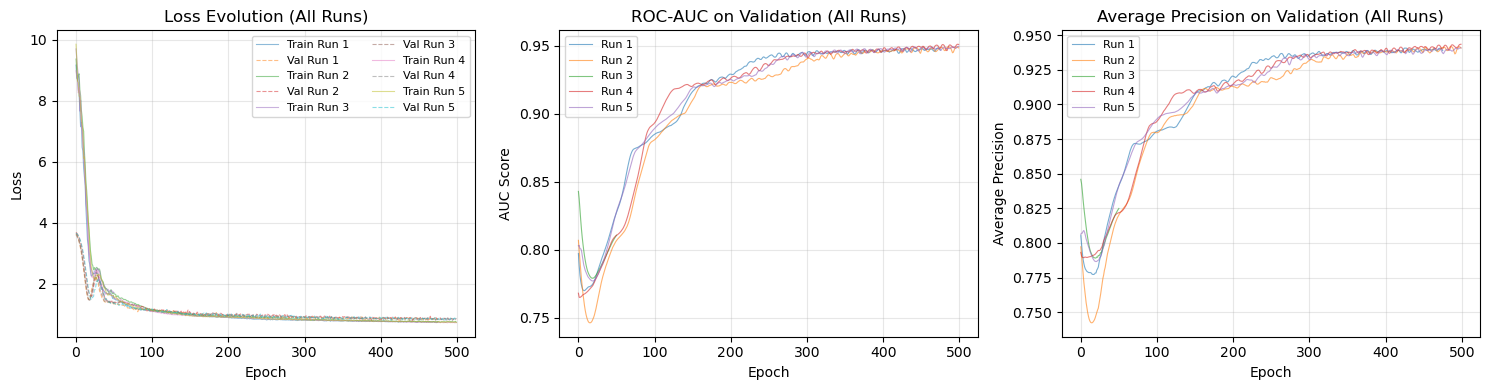

In [14]:
plot_training_curves(all_histories)

## 5 - GRAPH RECONSTRUCTION AND THRESHOLD SEARCH 🔍

In [15]:
# Use the model state from the *last* run to calculate Ahat
model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.train_pos_edge_index)
    Ahat = torch.sigmoid(z @ z.T).cpu().numpy()

# Get validation prediction scores
pos_pred = model.decode(z, data.val_pos_edge_index, sigmoid=True).cpu().numpy().flatten()
neg_pred = model.decode(z, data.val_neg_edge_index, sigmoid=True).cpu().numpy().flatten()
y_true_val = np.concatenate([np.ones(len(pos_pred)), np.zeros(len(neg_pred))])
y_pred_val = np.concatenate([pos_pred, neg_pred])

### OPTIMAL THRESHOLD SEARCH
precision, recall, thresholds = precision_recall_curve(y_true_val, y_pred_val)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold_f1 = thresholds[np.argmax(f1_scores[:-1])]

fpr, tpr, roc_thresholds = roc_curve(y_true_val, y_pred_val)
youden_idx = tpr - fpr
best_threshold_youden = roc_thresholds[np.argmax(youden_idx)]

all_scores = Ahat[np.triu_indices(Ahat.shape[0], k=1)]
target_ratio = (2 * G.number_of_edges() * 1.0) / (Ahat.shape[0] * (Ahat.shape[0] - 1))
best_threshold_density = np.percentile(all_scores, 100 - (100 * target_ratio))

best_threshold_ensemble = np.median([best_threshold_f1, best_threshold_youden, best_threshold_density])

# Test thresholds and find the best F1 score
results = []
thresholds_to_test = [
    (best_threshold_f1, "F1-score (Balanced Val)"),
    (best_threshold_youden, "Youden (Balanced Val)"),
    (best_threshold_density, "Density-based (Sparse Graph)"),
    (best_threshold_ensemble, "Ensemble (Median)"),
]

graphs = {}
reconstruction_metrics = {}
for threshold, name in thresholds_to_test:
    G_r, metrics, predicted_edges = reconstruct_graph(Ahat, G, threshold, name)
    graphs[name] = G_r
    reconstruction_metrics[name] = metrics
    results.append((name, threshold, predicted_edges, metrics['f1']))

best_result = max(results, key=lambda x: x[3])
best_method_name, best_threshold_final, _, _ = best_result
G_recon_best = graphs[best_method_name]

print(f"\n✅ BEST THRESHOLD: {best_method_name} ({best_threshold_final:.4f})")


📊 F1-score (Balanced Val)
  Threshold: 0.8392
  Original Edges: 8142
  Predicted Edges: 47008
  Common Edges: 7899 (97.02% Recall)
  Precision: 16.80%
  F1-score: 28.6455

📊 Youden (Balanced Val)
  Threshold: 0.8854
  Original Edges: 8142
  Predicted Edges: 37096
  Common Edges: 7652 (93.98% Recall)
  Precision: 20.63%
  F1-score: 33.8300

📊 Density-based (Sparse Graph)
  Threshold: 0.9896
  Original Edges: 8142
  Predicted Edges: 8142
  Common Edges: 4531 (55.65% Recall)
  Precision: 55.65%
  F1-score: 55.6497

📊 Ensemble (Median)
  Threshold: 0.8854
  Original Edges: 8142
  Predicted Edges: 37096
  Common Edges: 7652 (93.98% Recall)
  Precision: 20.63%
  F1-score: 33.8300

✅ BEST THRESHOLD: Density-based (Sparse Graph) (0.9896)


## 6 - Visualize Probability Distribution and PR Curve 📊


--- Plotting Reconstruction Analysis ---


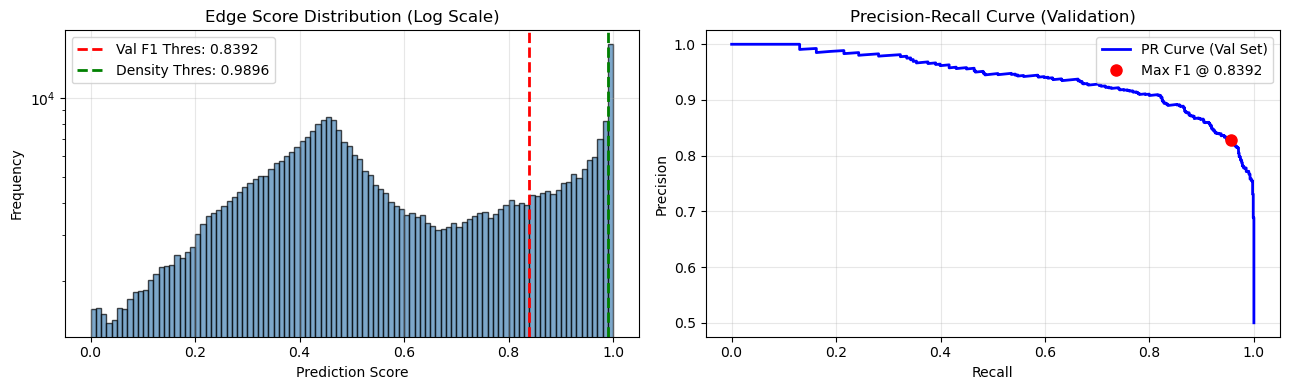

In [16]:
plot_reconstruction_analysis(Ahat, y_true_val, y_pred_val, best_threshold_f1, best_threshold_density)

## 7 - Comprehensive Summary and Final Graph Visualization 🌍


📝 COMPREHENSIVE FINAL REPORT

🎯 TEST SET PERFORMANCE:
  Test AUC: 0.9300 ± 0.0700
  Test AP:  0.9292 ± 0.0611

🔍 GRAPH RECONSTRUCTION (Best Method: Density-based (Sparse Graph)):
  Optimal threshold: 0.9896
  Original edges: 8142
  Reconstructed edges: 8142
  Precision: 55.65%
  Recall: 55.65%
  F1-score: 55.6497


--- Plotting Geographical Comparison ---


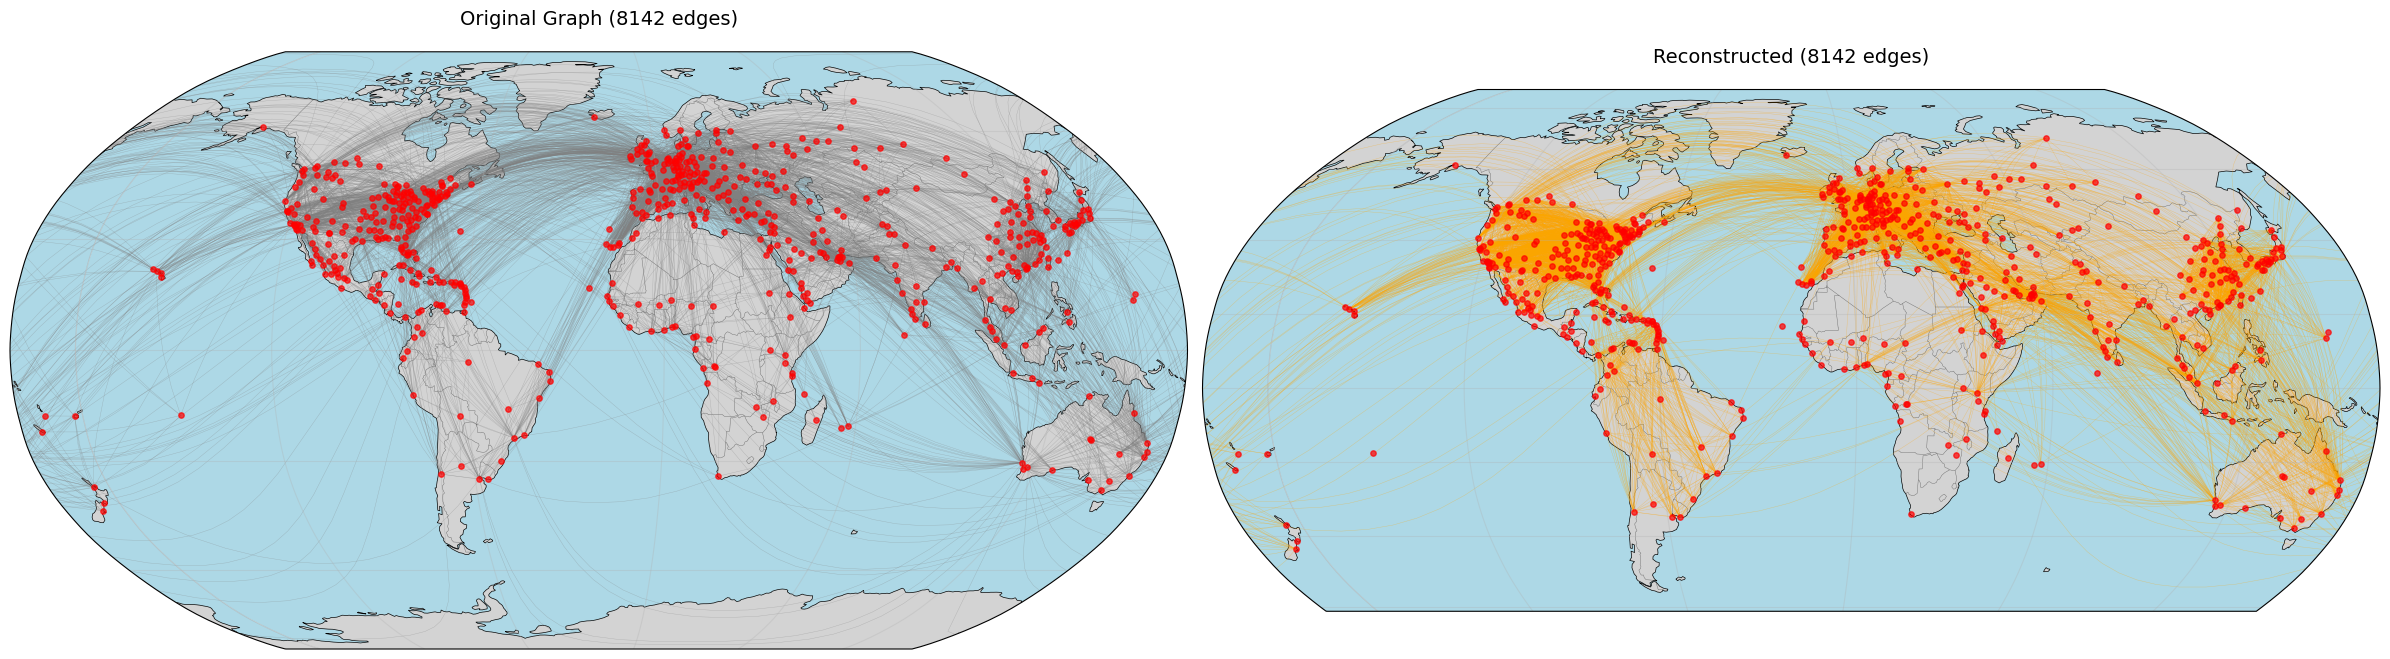

In [17]:
# Report Final Summary
best_metrics = reconstruction_metrics[best_method_name]
print("\n" + "="*70)
print("📝 COMPREHENSIVE FINAL REPORT")
print("="*70)

print(f"\n🎯 TEST SET PERFORMANCE:")
print(f"  Test AUC: {mean_auc:.4f} ± {ci_auc:.4f}")
print(f"  Test AP:  {mean_ap:.4f} ± {ci_ap:.4f}")

print(f"\n🔍 GRAPH RECONSTRUCTION (Best Method: {best_method_name}):")
print(f"  Optimal threshold: {best_threshold_final:.4f}")
print(f"  Original edges: {G.number_of_edges()}")
print(f"  Reconstructed edges: {len(G_recon_best.edges())}")
print(f"  Precision: {best_metrics['precision']:.2f}%")
print(f"  Recall: {best_metrics['recall']:.2f}%")
print(f"  F1-score: {best_metrics['f1']:.4f}")

print("\n" + "="*70)

# Plot Geographical Comparison
plot_geographical_comparison(G, G_recon_best)